In [ ]:
#Author: Khursheed Akram

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

# Load and Preprocess Data

In [3]:
df = pd.read_csv('FE_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
duplicates = df.index.duplicated(keep=False)
if duplicates.any():
    df = df[~duplicates]
df = df.asfreq('H')
df['FE_MW'] = df['FE_MW'].interpolate()

# Display First Few Rows of Data

In [4]:
df.head()

,FE_MW
Datetime,
2011-06-01 01:00:00,0.0
2011-06-01 02:00:00,8548.0
2011-06-01 03:00:00,8121.0
2011-06-01 04:00:00,7801.0
2011-06-01 05:00:00,7729.0


# Display Last Few Rows of Data

In [5]:
df.tail()

,FE_MW
Datetime,
2018-08-02 20:00:00,9866.0
2018-08-02 21:00:00,9656.0
2018-08-02 22:00:00,9532.0
2018-08-02 23:00:00,8872.0
2018-08-03 00:00:00,8198.0


# Plot Time Series Data

<AxesSubplot:title={'center':'Energy Consumption Over Time'}, xlabel='Datetime', ylabel='Megawatts'>

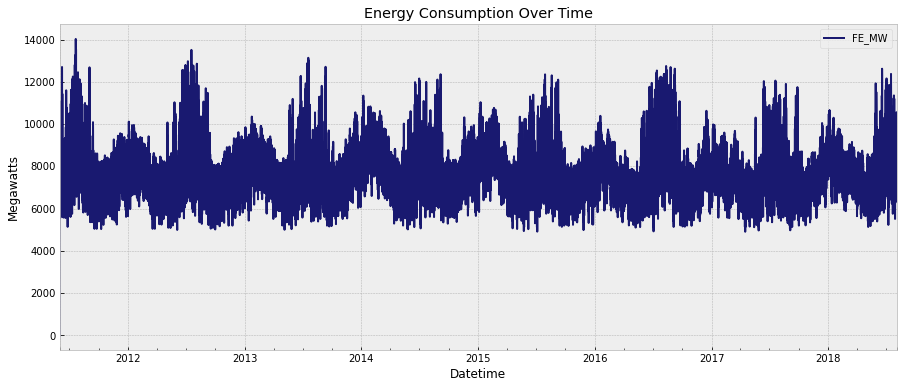

In [6]:
df.plot(figsize=(15,6),title='Energy Consumption Over Time', ylabel='Megawatts', color='midnightblue')

# Decompose and Plot Seasonal Components

Text(0, 0.5, 'Residual')

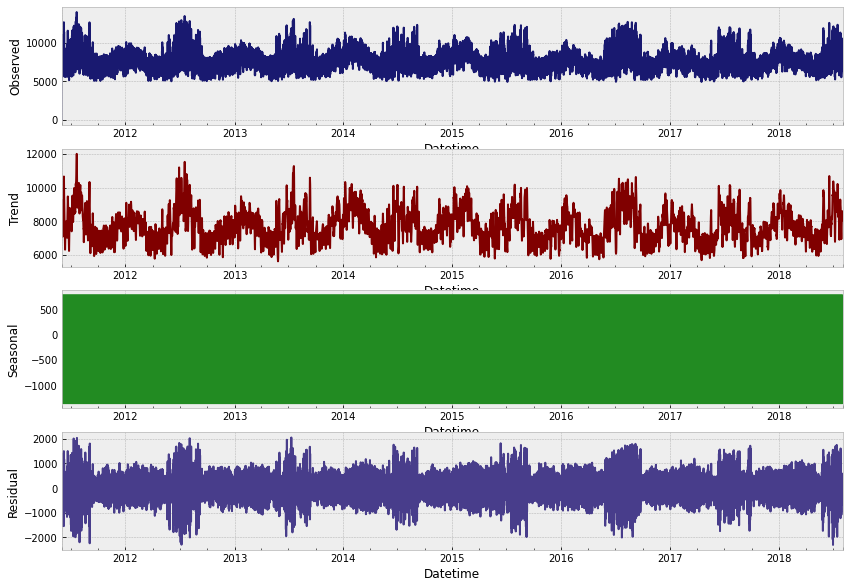

In [7]:
sd = seasonal_decompose(df['FE_MW'])
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10))

sd.observed.plot(ax=ax1, color='midnightblue')
ax1.set_ylabel('Observed')

sd.trend.plot(ax=ax2, color='maroon')
ax2.set_ylabel('Trend')

sd.seasonal.plot(ax=ax3, color='forestgreen')
ax3.set_ylabel('Seasonal')

sd.resid.plot(ax=ax4, color='darkslateblue')
ax4.set_ylabel('Residual')

# Scale the Dataset

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Create a dataset with look back timestamps

In [9]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 24 
X, Y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split Data into Training and Testing Sets

In [10]:
print(len(df))
split_point= int(len(X) * 0.67)
X_train, X_test = X[:split_point], X[split_point:]
Y_train, Y_test = Y[:split_point], Y[split_point:]

62880


# Build the LSTM Model

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model

In [12]:
model.fit(X_train, Y_train, batch_size=1, epochs=1)

42113/42113 [==============================] - 921s 22ms/step - loss: 3.8308e-04


# Predictions

In [13]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

649/649 [==============================] - 10s 15ms/step


# Inverse Transform the Predictions

In [14]:
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Plot the Predictions

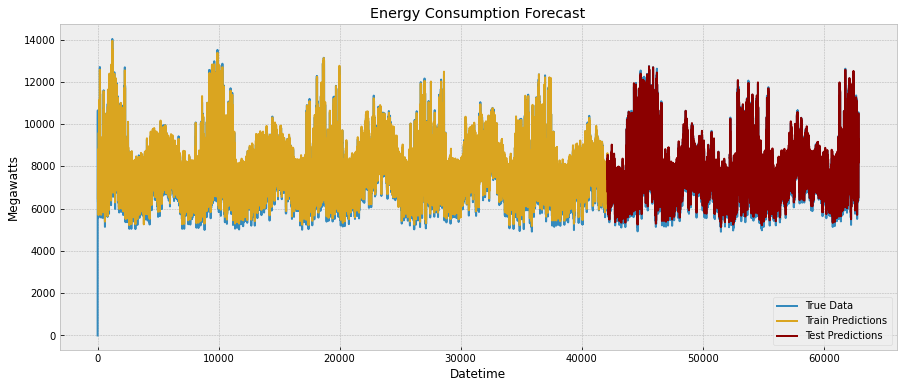

In [15]:
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, 0] = train_predict[:, 0]

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back):len(scaled_data), 0] = test_predict[:, 0]

plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='True Data')
plt.plot(train_predict_plot, label='Train Predictions',color='goldenrod')
plt.plot(test_predict_plot, label='Test Predictions',color='darkred')
plt.title('Energy Consumption Forecast')
plt.xlabel('Datetime')
plt.ylabel('Megawatts')
plt.legend()
plt.show()